In [ ]:
!pip install ml_collections
!pip install perceiver-pytorch

In [ ]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip -qq 'tiny-imagenet-200.zip'

In [ ]:
from ml_collections import ConfigDict

def C(**kwargs):
    return ConfigDict(initial_dictionary=kwargs)

# Config for CIFAR-10
def get_config():
    return C(
        cuda                = True,
        dataset             = 'cifar10',
        image_size          = 32,
        num_classes         = 10,

        train=C(
            batch_size          = 128,
            num_epochs          = 100,
        ),

        optimizer_type      = 'adamw',
        optimizer_args=C(
            lr                  = 3e-4,
        ),

        model_type          = 'perceiver_io',
        model_args=C(
            dim = 32 * 32 * 3,                    # dimension of sequence to be encoded
            queries_dim = 10,            # dimension of decoder queries
            logits_dim = 10,            # dimension of final logits
            depth = 2,                   # depth of net
            num_latents = 32,           # number of latents, or induced set points, or centroids. different papers giving it different names
            latent_dim = 64,            # latent dimension
            cross_heads = 1,             # number of heads for cross attention. paper said 1
            latent_heads = 8,            # number of heads for latent self attention, 8
            cross_dim_head = 128,         # number of dimensions per cross attention head
            latent_dim_head = 128,        # number of dimensions per latent self attention head
            weight_tie_layers = False,    # whether to weight tie layers (optional, as indicated in the diagram)
            decoder_ff = False
        ),
    )

# config for STL-10
# def get_config():
#     return C(
#         cuda                = True,
#         dataset             = 'stl10',
#         image_size          = 96,
#         num_classes         = 10,

#         train=C(
#             batch_size          = 16,
#             num_epochs          = 100,
#         ),

#         optimizer_type      = 'adamw',
#         optimizer_args=C(
#             lr                  = 3e-4,
#         ),

#         model_type          = 'perceiver_io',
#         model_args=C(
#             dim = 96 * 96 * 3,                    # dimension of sequence to be encoded
#             queries_dim = 10,            # dimension of decoder queries
#             logits_dim = 10,            # dimension of final logits
#             depth = 2,                   # depth of net
#             num_latents = 96,           # number of latents, or induced set points, or centroids. different papers giving it different names
#             latent_dim = 96 * 2,            # latent dimension
#             cross_heads = 1,             # number of heads for cross attention. paper said 1
#             latent_heads = 8,            # number of heads for latent self attention, 8
#             cross_dim_head = 64,         # number of dimensions per cross attention head
#             latent_dim_head = 64,        # number of dimensions per latent self attention head
#             weight_tie_layers = False,    # whether to weight tie layers (optional, as indicated in the diagram)
#             decoder_ff = False
#         ),
#     )

# # config for TinyImageNet
# def get_config():
#     return C(
#         cuda                = True,
#         dataset             = 'tinyimagenet',
#         image_size          = 64,
#         num_classes         = 200,

#         train=C(
#             batch_size          = 128,
#             num_epochs          = 100,
#         ),

#         optimizer_type      = 'adamw',
#         optimizer_args=C(
#             lr                  = 3e-4,
#         ),

#         model_type          = 'perceiver_io',
#         model_args=C(
#             dim = 64 * 64 * 3,                    # dimension of sequence to be encoded
#             queries_dim = 200,            # dimension of decoder queries
#             logits_dim = 200,            # dimension of final logits
#             depth = 2,                   # depth of net
#             num_latents = 32,           # number of latents, or induced set points, or centroids. different papers giving it different names
#             latent_dim = 32 * 2,            # latent dimension
#             cross_heads = 1,             # number of heads for cross attention. paper said 1
#             latent_heads = 8,            # number of heads for latent self attention, 8
#             cross_dim_head = 64,         # number of dimensions per cross attention head
#             latent_dim_head = 64,        # number of dimensions per latent self attention head
#             weight_tie_layers = False,    # whether to weight tie layers (optional, as indicated in the diagram)
#             decoder_ff = False
#         ),
#     )

In [ ]:
def load_config(config_name):
    return {
        'perceiver_io': get_config(),
    }[config_name]

In [27]:
import os
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from PIL import Image
from perceiver_pytorch import Perceiver, PerceiverIO
from sklearn.model_selection import train_test_split

def get_datasets(dataset, data_root):
    assert dataset in ('stl10', 'cifar10', 'tinyimagenet')
    data_root = os.path.abspath(os.path.expanduser(data_root))
    root_dir = os.path.join(data_root, dataset)
    if dataset == 'stl10':
      rt = transforms.RandomChoice([
          transforms.ColorJitter(0.2, 0.2, 0.2, 0.2),
          transforms.RandomHorizontalFlip(),
          transforms.RandomVerticalFlip(),
          transforms.RandomRotation(degrees=(0, 180)),
          transforms.transforms.RandomResizedCrop(96, scale=(0.5, 1)),
          transforms.RandomAffine(degrees=15, translate=(0.2, 0.2),
                          scale=(0.8, 1.2), shear=15,
                          resample=Image.BILINEAR),
          transforms.RandomEqualize(),
          transforms.RandomAutocontrast(),
          transforms.RandomAdjustSharpness(sharpness_factor=2),
      ])
      transform = []
      transform.append(
                  transforms.RandomChoice([
                      rt,
                      transforms.Compose([rt, rt]),
                      transforms.Compose([rt, rt, rt]),
                      transforms.Compose([rt, rt, rt, rt]),
                  ])
              )
      transform.extend([
          transforms.ToTensor(),
          transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
      ])
      transform_train = transforms.Compose(transform)
    elif dataset == 'tinyimagenet':
      rt = transforms.RandomChoice([
          transforms.ColorJitter(0.2, 0.2, 0.2, 0.2),
          transforms.RandomHorizontalFlip(),
          transforms.RandomVerticalFlip(),
          transforms.RandomRotation(degrees=(0, 180)),
          transforms.transforms.RandomResizedCrop(64, scale=(0.5, 1)),
          transforms.RandomAffine(degrees=15, translate=(0.2, 0.2),
                          scale=(0.8, 1.2), shear=15,
                          resample=Image.BILINEAR),
          transforms.RandomEqualize(),
          transforms.RandomAutocontrast(),
          transforms.RandomAdjustSharpness(sharpness_factor=2),
      ])
      transform = []
      transform.append(
                  transforms.RandomChoice([
                      rt,
                      transforms.Compose([rt, rt]),
                      transforms.Compose([rt, rt, rt]),
                      transforms.Compose([rt, rt, rt, rt]),
                  ])
              )
      transform.extend([
          transforms.ToTensor(),
          transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
      ])
      transform_train = transforms.Compose(transform)
    else:
      transform_train = transforms.Compose([
        transforms.RandomHorizontalFlip(p = 0.5),
        transforms.ColorJitter(brightness=0.5, hue = 0.25),
        transforms.ToTensor(),
      ])

    transform_test = transforms.Compose([
      transforms.RandomHorizontalFlip(p = 0.5),
      transforms.ColorJitter(brightness=0.5, hue = 0.25),
        transforms.ToTensor(),
    ])
    if dataset == 'stl10':
        train_dataset = datasets.STL10(root=root_dir, split='train', transform=transform_train, download=True)
        test_dataset = datasets.STL10(root=root_dir, split='test', transform=transform_test, download=True)
    elif dataset == 'cifar10':
        train_dataset = datasets.CIFAR10(root=root_dir, train=True, download=True, transform=transform_train)
        test_dataset = datasets.CIFAR10(root=root_dir, train=False, download=True, transform=transform_test)
    elif dataset == 'tinyimagenet':
      val_img_dir = './tiny-imagenet-200/val/images'
      if os.path.exists(val_img_dir):
          print("FIX")
          data = open('./tiny-imagenet-200/val/val_annotations.txt', 'r').readlines()
          val_img_dict = {}
          for line in data:
              words = line.split('\t')
              val_img_dict[words[0]] = words[1]

          for img, folder in val_img_dict.items():
              new_dir = f'./tiny-imagenet-200/val/{folder}'
              os.makedirs(new_dir, exist_ok=True)
              old_file = f'{val_img_dir}/{img}'
              if os.path.exists(old_file):
                  os.rename(old_file, f'{new_dir}/{img}')

          import shutil
          shutil.rmtree(val_img_dir)
      train_dataset = datasets.ImageFolder(root='./tiny-imagenet-200/train', transform=transform_train)
      test_dataset = datasets.ImageFolder(root='./tiny-imagenet-200/val', transform=transform_test)

    return train_dataset, test_dataset

def get_model(config):
    model_cls = {'perceiver': Perceiver,
                 'perceiver_io': PerceiverIO
                 }[config.model_type]
    model = model_cls(**config.model_args)
    param_count = sum(np.prod(p.shape).item() for p in model.parameters())
    print(f'Created {config.model_type} model with {param_count} parameters.')
    if config.cuda:
        model.cuda()
    temp = torch.nn.Parameter(torch.rand(config.train['batch_size'], 1, config['num_classes']), requires_grad = True)
    model.register_parameter(name='query_io', param=temp)
    return model

def get_optimizer(model, config):
    optimizer_cls = {'adamw': optim.AdamW,
                     'rmsprop': optim.RMSprop
                     }[config.optimizer_type]
    optimizer = optimizer_cls(model.parameters(), **config.optimizer_args)
    return optimizer

def train(config):
    train_dataset, test_dataset = get_datasets(config.dataset, 'data')
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config.train.batch_size,
                                               shuffle=True, pin_memory=config.cuda, drop_last=False)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=config.train.batch_size,
                                              shuffle=False, pin_memory=config.cuda, drop_last=False)
    model = get_model(config)
    opt = get_optimizer(model, config)

    total_steps = 0
    for epoch in range(1, config.train.num_epochs+1):
        print(f'Starting epoch {epoch}')

        for _, (x, y) in enumerate(train_loader):
            total_steps += 1
            if len(x) != config.train['batch_size']:
              break
            if config.cuda:
                x, y = x.cuda(), y.cuda()
            x = x.permute(0, 2, 3, 1) * 2 - 1
            x = torch.flatten(x, start_dim = 1, end_dim = 3)
            queries = model.query_io.data
            queries = queries.cuda()
            y_hat = model(x[:, None, :], queries = queries).squeeze()
            opt.zero_grad()
            loss = F.cross_entropy(y_hat, y)
            loss.backward()
            opt.step()
            if total_steps % 100 == 0:
                print(f'epoch {epoch} step {total_steps} loss {loss.item():.4f}')
        print(f'epoch {epoch} step {total_steps} loss {loss.item():.4f}')

        ep_train_loss, ep_train_acc = evaluate(model, train_dataset, config)
        print(f'epoch {epoch} Train accuracy: {ep_train_acc:.4f} loss: {ep_train_loss:.4f}')
        ep_test_loss, ep_test_acc = evaluate(model, test_dataset, config)
        print(f'epoch {epoch} Test accuracy: {ep_test_acc:.4f} loss: {ep_test_loss:.4f}')
        print()


@torch.no_grad()
def evaluate(model, dataset, config):
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=config.train.batch_size,
                                              shuffle=False, pin_memory=config.cuda,
                                              drop_last=False)
    model.eval()
    losses, preds = [], []
    for x, y in data_loader:
        if len(x) != config.train['batch_size']:
            break
        if config.cuda:
            x, y = x.cuda(), y.cuda()
        x = x.permute(0, 2, 3, 1) * 2 - 1
        x = torch.flatten(x, start_dim = 1, end_dim = 3)
        queries = model.query_io.data
        queries = queries.cuda()
        y_hat = model(x[:, None, :], queries = queries).squeeze()
        y_pred = y_hat.argmax(axis=-1)
        loss = F.cross_entropy(y_hat, y, reduction='none')
        pred = (y_pred == y).long()
        losses.append(loss)
        preds.append(pred)

    avg_loss = torch.cat(losses).cpu().mean().item()
    accuracy = torch.cat(preds).cpu().float().mean().item()

    return avg_loss, accuracy


In [ ]:
config = load_config('perceiver_io')
train(config)

## CIFAR-10 Plots

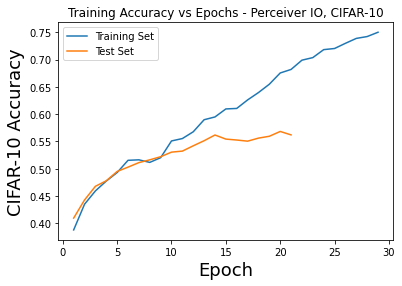

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Model Parameters
# dim = 32 * 32 * 3,                    # dimension of sequence to be encoded
# queries_dim = 10,            # dimension of decoder queries
# logits_dim = 10,            # dimension of final logits
# depth = 2,                   # depth of net
# num_latents = 32,           # number of latents, or induced set points, or centroids. different papers giving it different names
# latent_dim = 64,            # latent dimension
# cross_heads = 1,             # number of heads for cross attention. paper said 1
# latent_heads = 8,            # number of heads for latent self attention, 8
# cross_dim_head = 128,         # number of dimensions per cross attention head
# latent_dim_head = 128,        # number of dimensions per latent self attention head
# weight_tie_layers = False,    # whether to weight tie layers (optional, as indicated in the diagram)
# decoder_ff = False

epoch_train = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
epoch_test = epoch_train[0:21]
train_acc = [0.3877, 0.4348, 0.4592, 0.4773, 0.4929, 0.5153, 0.5162, 0.5115, 0.5201, 0.5508, 0.5552, 0.5676, 0.5897, 0.5948, 0.6095, 0.6104, 0.6260, 0.6395, 0.6548, 0.6754, 0.6819, 0.6989, 0.7036, 0.7182, 0.7203, 0.7298, 0.7388, 0.7422, 0.7501]
test_acc = [0.4094, 0.4426, 0.4677, 0.4778, 0.4949, 0.5028, 0.5111, 0.5162, 0.5219, 0.5303, 0.5322, 0.5419, 0.5512, 0.5617, 0.5542, 0.5525, 0.5504, 0.5560, 0.5594, 0.5682, 0.5619]

plt.plot(epoch_train, train_acc, label = "Training Set")
plt.plot(epoch_test, test_acc, label = "Test Set")
plt.title("Training Accuracy vs Epochs - Perceiver IO, CIFAR-10")
plt.legend()
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('CIFAR-10 Accuracy', fontsize = 18)
plt.show()


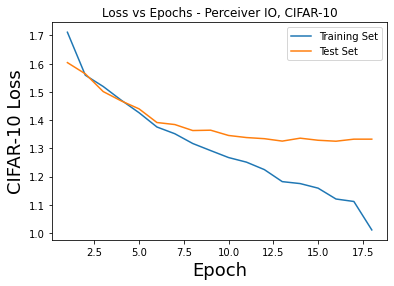

In [ ]:
epochs = [i for i in range(1, 19)]
train_loss = [1.7115, 1.5592, 1.5191, 1.4709, 1.4262, 1.3755, 1.3516, 1.3170, 1.2919, 1.2672, 1.2509, 1.2244, 1.1818, 1.1749, 1.1587, 1.1202, 1.1114, 1.0106]
test_loss = [1.6038, 1.5640, 1.5011, 1.4682, 1.4399, 1.3914, 1.3842, 1.3630, 1.3642, 1.3455, 1.3381, 1.3341, 1.3255, 1.3359, 1.3285, 1.3251, 1.3324, 1.3324]

plt.plot(epochs, train_loss, label = "Training Set")
plt.plot(epochs, test_loss, label = "Test Set")
plt.title("Loss vs Epochs - Perceiver IO, CIFAR-10")
plt.legend()
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('CIFAR-10 Loss', fontsize = 18)
plt.show()

## STL-10 Plots

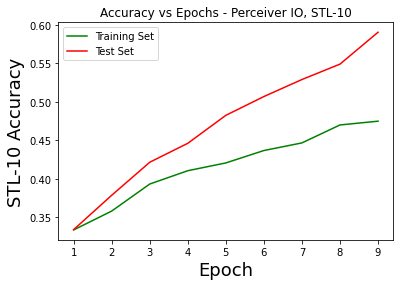

In [51]:
# Model Parameters for STL-10 Task
# dim = 96 * 96 * 3,                    # dimension of sequence to be encoded
# queries_dim = 10,            # dimension of decoder queries
# logits_dim = 10,            # dimension of final logits
# depth = 2,                   # depth of net
# num_latents = 96,           # number of latents, or induced set points, or centroids. different papers giving it different names
# latent_dim = 96 * 2,            # latent dimension
# cross_heads = 1,             # number of heads for cross attention. paper said 1
# latent_heads = 8,            # number of heads for latent self attention, 8
# cross_dim_head = 64,         # number of dimensions per cross attention head
# latent_dim_head = 64,        # number of dimensions per latent self attention head
# weight_tie_layers = False,    # whether to weight tie layers (optional, as indicated in the diagram)
# decoder_ff = False

epochs = [i for i in range(1, 10)]

test_acc =  [0.3340, 0.3786, 0.4215, 0.4461, 0.4824, 0.5068, 0.5289, 0.5489, 0.5903]
train_acc = [0.3336, 0.3581, 0.3932, 0.4105, 0.4206, 0.4367, 0.4466, 0.4699, 0.4748]

plt.plot(epochs, train_acc, label = "Training Set", color = "green")
plt.plot(epochs, test_acc, label = "Test Set", color = "red")
plt.title("Accuracy vs Epochs - Perceiver IO, STL-10")
plt.legend()
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('STL-10 Accuracy', fontsize = 18)
plt.show()

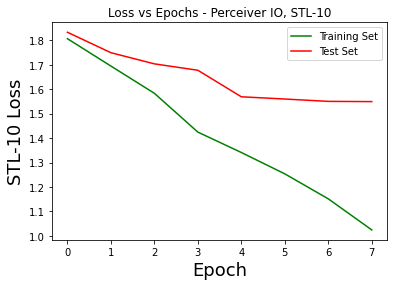

In [55]:
train_loss = [1.8068, 1.6947, 1.5832, 1.4244, 1.3409, 1.2535, 1.1512, 1.0241] 
test_loss =  [1.8331, 1.7494, 1.7037, 1.6775, 1.6689, 1.6598, 1.6502, 1.6492]

plt.plot(epochs[0:8], train_loss, label = "Training Set", color = "green")
plt.plot(epochs[0:8], test_loss, label = "Test Set", color = "red")
plt.title("Loss vs Epochs - Perceiver IO, STL-10")
plt.legend()
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('STL-10 Loss', fontsize = 18)
plt.show()

# TinyImageNet Plots



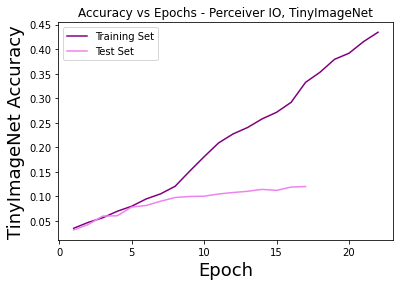

In [53]:
import matplotlib.pyplot as plt
import numpy as np

# Model Parameters for TinyImageNet Task
# dim = 64 * 64 * 3,                    # dimension of sequence to be encoded
# queries_dim = 200,            # dimension of decoder queries
# logits_dim = 200,            # dimension of final logits
# depth = 2,                   # depth of net
# num_latents = 32,           # number of latents, or induced set points, or centroids. different papers giving it different names
# latent_dim = 32 * 2,            # latent dimension
# cross_heads = 1,             # number of heads for cross attention. paper said 1
# latent_heads = 8,            # number of heads for latent self attention, 8
# cross_dim_head = 64,         # number of dimensions per cross attention head
# latent_dim_head = 64,        # number of dimensions per latent self attention head
# weight_tie_layers = False,    # whether to weight tie layers (optional, as indicated in the diagram)
# decoder_ff = False


epochs = [i for i in range(1, 23)]
train_acc =  [0.0350, 0.0470, 0.0564, 0.0696, 0.0799, 0.09479, 0.1052, 0.1206, 0.1513, 0.1808, 0.2090, 0.2273, 0.2404, 0.2579, 0.2714, 0.2916, 0.3324, 0.3531, 0.3793, 0.3918, 0.4154, 0.4345]
test_acc = [0.0317, 0.0427, 0.0598, 0.0605, 0.0782, 0.08148, 0.0902, 0.0977, 0.0998, 0.1004, 0.1049, 0.1079, 0.1104, 0.1143, 0.1122, 0.1190, 0.1201]
plt.plot(epochs, train_acc, label = "Training Set", color = "purple")
plt.plot(epochs[0:17], test_acc, label = "Test Set", color = "violet")
plt.title("Accuracy vs Epochs - Perceiver IO, TinyImageNet")
plt.legend()
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('TinyImageNet Accuracy', fontsize = 18)
plt.show()

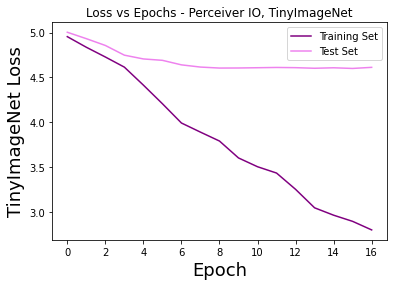

In [54]:
epochs = [i for i in range(17)]

train_loss = [4.9543, 4.8362, 4.7277, 4.6148, 4.4146, 4.2074, 3.9927, 3.8911, 3.7919, 3.6036, 3.5058, 3.4354, 3.2541, 3.0483, 2.9661, 2.8975, 2.8022]
test_loss =  [5.0033, 4.9318, 4.8562, 4.7481, 4.7060, 4.6906, 4.6401, 4.6155, 4.6045, 4.6053, 4.6082, 4.6112, 4.6089, 4.6022, 4.6076, 4.6002, 4.6124]

plt.plot(epochs, train_loss, label = "Training Set", color = "purple")
plt.plot(epochs, test_loss, label = "Test Set", color = "violet")
plt.title("Loss vs Epochs - Perceiver IO, TinyImageNet")
plt.legend()
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('TinyImageNet Loss', fontsize = 18)
plt.show()

## Ablation Study - Batch Size CIFAR-10

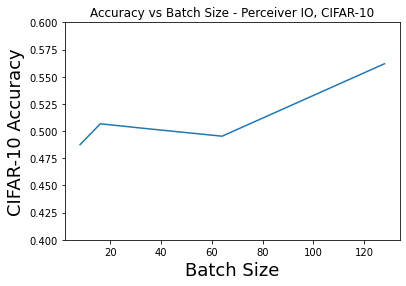

In [ ]:
# Batch Size Ablation, CIFAR-10, fixed learning rate = 3e-4
# Fixed model architecture for ablation study
# Model Parameters
# dim = 32 * 32 * 3,                    # dimension of sequence to be encoded
# queries_dim = 10,            # dimension of decoder queries
# logits_dim = 10,            # dimension of final logits
# depth = 2,                   # depth of net
# num_latents = 32,           # number of latents, or induced set points, or centroids. different papers giving it different names
# latent_dim = 64,            # latent dimension
# cross_heads = 1,             # number of heads for cross attention. paper said 1
# latent_heads = 8,            # number of heads for latent self attention, 8
# cross_dim_head = 128,         # number of dimensions per cross attention head
# latent_dim_head = 128,        # number of dimensions per latent self attention head
# weight_tie_layers = False,    # whether to weight tie layers (optional, as indicated in the diagram)
# decoder_ff = False

axes = plt.gca()
axes.set_ylim([0.4,0.6])
batch_size = [8, 16, 32, 64, 128]
final_test_accuracies = [0.4875, 0.5067, 0.5028, 0.4953, 0.5619]
plt.plot(batch_size, final_test_accuracies)
plt.title("Accuracy vs Batch Size - Perceiver IO, CIFAR-10")
plt.xlabel('Batch Size', fontsize = 18)
plt.ylabel('CIFAR-10 Accuracy', fontsize = 18)
plt.show()

## Ablation Study - Learning Rate CIFAR-10

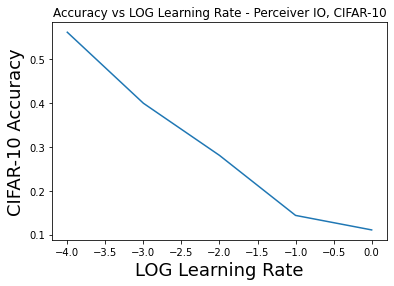

In [ ]:
# Learning Rate Ablation , 12 epochs, CIFAR-10, fixed batch size = 128
# Fixed model architecture for ablation study
# Model Parameters
# dim = 32 * 32 * 3,                    # dimension of sequence to be encoded
# queries_dim = 10,            # dimension of decoder queries
# logits_dim = 10,            # dimension of final logits
# depth = 2,                   # depth of net
# num_latents = 32,           # number of latents, or induced set points, or centroids. different papers giving it different names
# latent_dim = 64,            # latent dimension
# cross_heads = 1,             # number of heads for cross attention. paper said 1
# latent_heads = 8,            # number of heads for latent self attention, 8
# cross_dim_head = 128,         # number of dimensions per cross attention head
# latent_dim_head = 128,        # number of dimensions per latent self attention head
# weight_tie_layers = False,    # whether to weight tie layers (optional, as indicated in the diagram)
# decoder_ff = False

learning_rate = [0, -1, -2, -3, -4]
final_test_accuracies = [0.1108, 0.1439, 0.2809, 0.3999, 0.5619]

axes = plt.gca()
plt.plot(learning_rate, final_test_accuracies)
plt.title("Accuracy vs LOG Learning Rate - Perceiver IO, CIFAR-10")
plt.xlabel('LOG Learning Rate', fontsize = 18)
plt.ylabel('CIFAR-10 Accuracy', fontsize = 18)
plt.show()
